In [1]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
from matplotlib.pylab import date2num
import seaborn as sns
from scipy import mat, linalg
import math

In [2]:
from local_utilities import load_as_df, find_ticks

In [3]:
stock_basic = load_as_df('select * from base_stocks')
stock_basic = stock_basic.set_index('ts_code')

In [4]:
ts_list = ['000573.SZ', '000751.SZ', '000630.SZ', '000521.SZ']
tick_list = [find_ticks(ts_code=tscode) for tscode in ts_list]

In [5]:
close_list = []
for ticks in tick_list:
    close_list.append(ticks.close)


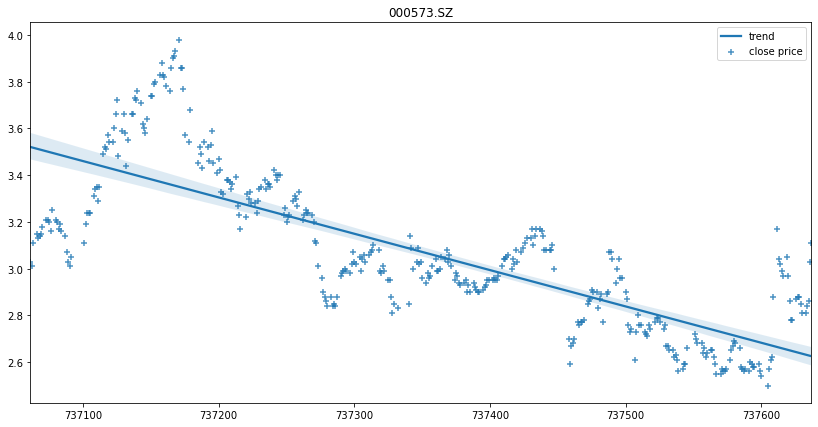

In [6]:
ts_code = ts_list[0]
t1 = find_ticks(ts_code)
axe = plt.figure(figsize=(14, 7))
sns.regplot(x=date2num(t1.trade_date), y=t1.close.values, marker='+')
# axe.autofmt_xdate()
# axe.set_xticklabels(t1.trade_date)
plt.title(ts_code)
plt.legend(['trend', 'close price'], loc='best')
plt.show()

In [7]:
import statsmodels.api as sm
from statsmodels import regression

In [8]:
t1 = find_ticks(ts_code)

In [9]:
y = np.array(t1.close)
x = np.arange(len(y))
scaler = x.max()/y.max()
y_arr = y * scaler

In [10]:
# 构造线性回归的常数项x1: y = x1 + a*x2
x_reg = sm.add_constant(x)
model = regression.linear_model.OLS(y_arr, x_reg).fit()

In [11]:
# 趋势角度，可以用来进行涨跌趋势的判断
rad = np.rad2deg(model.params[1])
# y_reg = x * math.tan(rad) + model.params[0]
y_reg = x * model.params[1] + model.params[0]

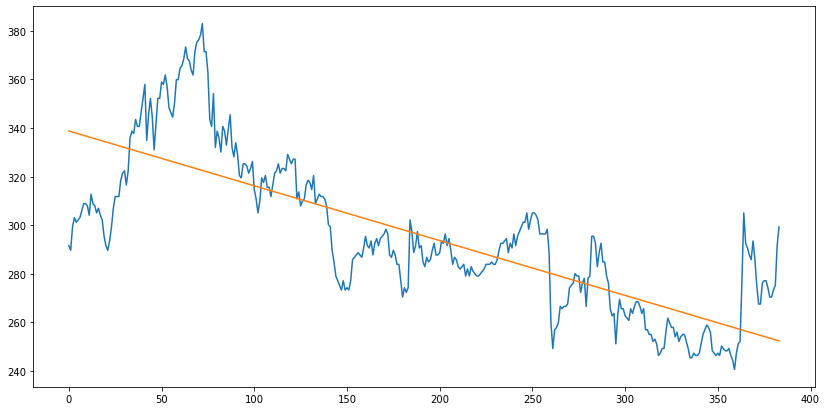

rad:-12.927744689259406, m0:338.78096376770213, m1:-0.22563170968478785


In [12]:
plt.figure(figsize=(14, 7))
plt.plot(x, y_arr)
plt.plot(x, y_reg)
plt.show()
print('rad:{}, m0:{}, m1:{}'.format(rad, model.params[0], model.params[1]))

In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     633.9
Date:                Tue, 18 Aug 2020   Prob (F-statistic):           3.76e-83
Time:                        13:41:51   Log-Likelihood:                -1683.8
No. Observations:                 384   AIC:                             3372.
Df Residuals:                     382   BIC:                             3380.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        338.7810      1.983    170.851      0.000     334.882     342.680
x1            -0.2256      0.009    -25.178      0.000      -0.243      -0.208
==============================================================================
Omnibus:                       12.943   Durbin-Watson:                   0.092
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.295
Skew:                           0.430   Prob(JB):                      0.00130
Kurtosis:                       3.301   Cond. No.                         442.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
mid_pos = int(len(t1)/2)
k1 = t1[:mid_pos].reset_index()
k2 = t1[mid_pos:].reset_index()

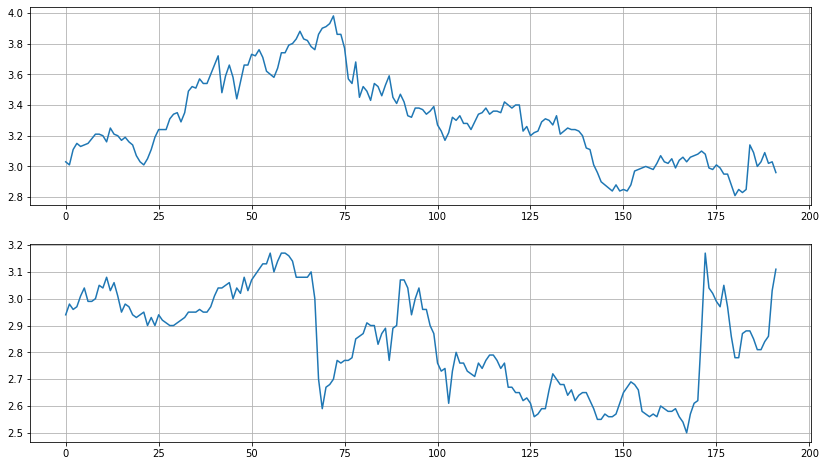

In [15]:
_, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
axes[0].plot(k1.close)
axes[0].grid(True)
axes[1].plot(k2.close)
axes[1].grid(True)
plt.show()

In [22]:
# 均值回复策略
k1.close.mean()
k2.close.mean()
k2.close.std()
sell_sig = k1.close.mean() + k1.close.std()/3
buy_sig = k1.close.mean() - k1.close.std()/3

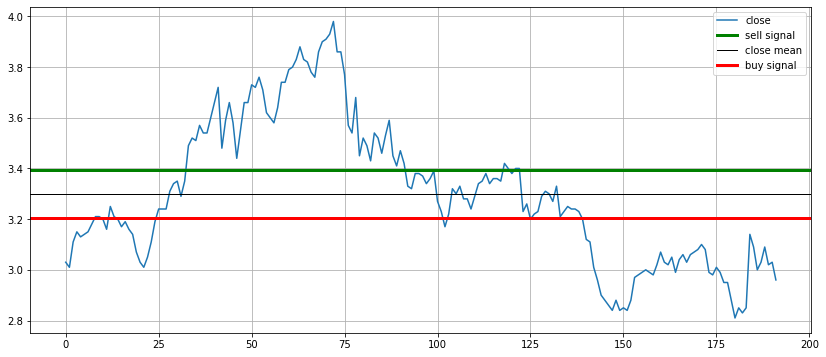

In [17]:
# 如果将测试数据t2带入，我们可以发现原指标完全无法使用。整体走势都在上一周期的最低之下
plt.figure(figsize=(14, 6))
k1.close.plot(grid=True)
plt.axhline(sell_sig, color='g', lw=3)
plt.axhline(k1.close.mean(), color='black', lw=1)
plt.axhline(buy_sig, color='r', lw=3)
plt.legend(['close', 'sell signal', 'close mean', 'buy signal'], loc='best')
plt.show()

In [60]:
# 添加signal字段记录买入卖出的取值区
k1.loc[k1[k1.close>=sell_sig].index, 'signal'] = 0
k1.loc[k1[k1.close<=buy_sig].index, 'signal'] = 1
# ffill 对signal列进行顺序填充，na填充为以上一个值，直到非NA的值出现
k1.signal.fillna(method='ffill', inplace=True)

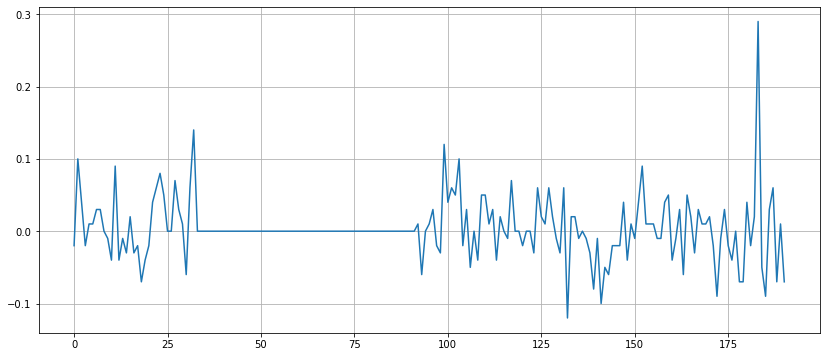

In [61]:
plt.figure(figsize=(14, 6))
plt.grid(True)
plt.plot((k1.shift(-1).close - k1.close)*k1.signal)
plt.show()